# Experiments analysis

## Dependencies

In [18]:
import json
import msgpack
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

## Variables

In [33]:
base_dir = "logs"

last_step = 3600

variations = [
    "nodes=100;unique_images=08",
    "nodes=100;unique_images=32",
    "nodes=196;unique_images=16",
    "nodes=196;unique_images=64",
]

logs = [
    ("central", "central;{variation}"),
    ("community", "community12p;{variation}"),
    ("community", "community25p;{variation}"),
    ("p2p", "p2p;{variation}"),
    ("dynamic", "p2p;{variation}"),
    ("resource_aware_dynamic", "p2p;{variation}", "1"),
    ("resource_aware_dynamic", "p2p;{variation}", "2"),
    ("resource_aware_dynamic", "p2p;{variation}", "3"),
    ("resource_aware_dynamic", "p2p;{variation}", "4"),
]

seed = "1"

algorithm_map = {
    "central": "Central",
    "community": "Comm.",
    "p2p": "P2P",
    "dynamic": "LM Dyn.",
    "resource_aware_dynamic": "RR Dyn.",
}

algorithm_labels = ["Central", "Comm.*", "Comm.+", "P2P", "LM Dyn.", "RR Dyn. (1)", "RR Dyn. (2)", "RR Dyn. (3)", "RR Dyn. (4)"]

## Base functions

### User data: latency

In [3]:
def get_user_data(variation, user_type=None):
    user_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Mean Latency": 0,
        }

        # Opening file
        user_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/User.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/User.msgpack"
        )
        user_file = open(user_msgpack_file, "rb")
        user_msgpack = msgpack.load(user_file)
        user_df = pd.DataFrame(user_msgpack)

        # Collecting information
        latency = (
            user_df[["Object", "Delays"]]
            if user_type is None
            else user_df[user_df["User Type"] == user_type][["Object", "Delays"]]
        )

        # Persisting information
        simulation_data["Mean Latency"] = latency["Delays"].mean()

        # Closing file
        user_file.close()

        # Appending data
        user_data.append(simulation_data)

    return pd.DataFrame(user_data)

In [4]:
user_data_dfs = {
    variation: get_user_data(variation)
    for variation in variations
}

### Registry data: registry usage and number of provisioned registries

In [5]:
def get_registry_data(variation):
    registry_data = []
    registry_data_per_time_step = {}

    for index, log in enumerate(logs):
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Values": [],
            "Values (w/o 0%)": [],
            "Mean": 0,
            "Mean Provisioned": 0,
        }

        # Opening file
        registry_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/ContainerRegistry.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/ContainerRegistry.msgpack"
        )
        registry_file = open(registry_msgpack_file, "rb")
        registry_msgpack = msgpack.load(registry_file)
        registry_df = pd.DataFrame(registry_msgpack)

        # Collecting information
        registry_filtered_data = (
            registry_df[registry_df["P2P"] == True][["Object", "Provisioning", "Not Provisioning"]]
            if log[1] == "p2p"
            else registry_df[["Object", "Provisioning", "Not Provisioning"]]
        )
        registry_data_grouped = registry_filtered_data.groupby("Object").sum()
        registry_data_grouped["Total Steps"] = registry_data_grouped.sum(axis=1)
        registry_data_grouped["Provisioning Percentage"] = registry_data_grouped["Provisioning"] / registry_data_grouped["Total Steps"]
        registry_data_grouped["Not Provisioning Percentage"] = registry_data_grouped["Not Provisioning"] / registry_data_grouped["Total Steps"]
        registries_per_time_step = registry_df[registry_df["Time Step"] > 0].groupby(["Time Step"]).count()["Object"]

        # Persisting information
        simulation_data["Values"] = registry_data_grouped["Provisioning Percentage"]
        simulation_data["Values (w/o 0%)"] = registry_data_grouped[registry_data_grouped["Provisioning Percentage"] > 0]["Provisioning Percentage"]
        simulation_data["Mean"] = registry_data_grouped["Provisioning Percentage"].mean()
        simulation_data["Mean Provisioned"] = registry_data_grouped["Total Steps"].sum() / last_step
        registry_data_per_time_step[algorithm_labels[index]] = registries_per_time_step

        # Closing file
        registry_file.close()

        # Appending data
        registry_data.append(simulation_data)

    return pd.DataFrame(registry_data), pd.concat(registry_data_per_time_step, axis=1)

In [6]:
registry_data_dfs = {
    variation: get_registry_data(variation)
    for variation in variations
}

### Edge Server data: computing resources utilization and disk utilization

In [7]:
def normalize_cpu_and_memory(cpu, memory) -> float:
    """Normalizes the CPU and memory values.

    Args:
        cpu (float): CPU value.
        memory (float): Memory value.

    Returns:
        normalized_value (float): Normalized value.
    """
    normalized_value = (cpu * memory) ** (1 / 2)
    return normalized_value
    
def get_server_data(variation):
    computing_utilization_data = {}
    disk_utilization_data = {}
    server_data = []

    for index, log in enumerate(logs):
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Mean Disk Occupation per Server": 0,
        }
        
        # Opening file
        server_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/EdgeServer.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/EdgeServer.msgpack"
        )
        server_file = open(server_msgpack_file, "rb")
        server_msgpack = msgpack.load(server_file)
        server_df = pd.DataFrame(server_msgpack)

        # Collecting information
        server_df = server_df[["Object", "CPU", "RAM", "CPU Demand", "RAM Demand", "Disk Demand", "Time Step"]]
        server_df["Normalized Utilization"] = server_df.apply(lambda row: normalize_cpu_and_memory(row["CPU Demand"], row["RAM Demand"])/normalize_cpu_and_memory(row["CPU"], row["RAM"]), axis=1)
        computing_utilization_per_time_step = server_df[server_df["Time Step"] > 0].groupby(["Time Step"])["Normalized Utilization"].mean()
        disk_utilization_per_time_step = server_df[server_df["Time Step"] > 0].groupby(["Time Step"])["Disk Demand"].sum()
        number_of_unique_servers = server_df["Object"].nunique()

        # Persisting information
        computing_utilization_data[algorithm_labels[index]] = computing_utilization_per_time_step
        disk_utilization_data[algorithm_labels[index]] = disk_utilization_per_time_step
        simulation_data["Total Disk Occupation"] = server_df["Disk Demand"].sum()
        simulation_data["Mean Disk Occupation per Server"] = simulation_data["Total Disk Occupation"] / (number_of_unique_servers * 3600)

        # Closing file
        server_file.close()

        # Appending data
        server_data.append(simulation_data)

    return pd.concat(computing_utilization_data, axis=1), pd.concat(disk_utilization_data, axis=1), pd.DataFrame(server_data)

In [8]:
server_data_dfs = {
    variation: get_server_data(variation)
    for variation in variations
}

### Application data: provisioning time and reallocations

In [9]:
def get_application_data(step, variation):
    service_data = []

    for log in logs:
        # Formatting log
        log = list(log)
        log[1] = log[1].format(variation=variation)

        simulation_data = {
            "Algorithm": f"{algorithm_map[log[0]]}" if len(log) == 2 else f"{algorithm_map[log[0]]} ({log[2]})",
            "Prov. Time Values": [],
            "Mean Prov. Time": 0,
            "Only Using Cache": 0,
            "Partially Using Cache": 0,
            "Not Using Cache": 0,
            "Total Migrations": 0,
            "Only Using Cache (%)": 0,
            "Partially Using Cache (%)": 0,
            "Not Using Cache (%)": 0,
        }

        # Opening file
        service_msgpack_file = (
            f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Service.msgpack"
            if len (log) == 2
            else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/Service.msgpack"
        )
        service_file = open(service_msgpack_file, "rb")
        service_msgpack = msgpack.load(service_file)
        service_df = pd.DataFrame(service_msgpack)

        # Collecting information
        migrations_duration = service_df[service_df["Time Step"] == step]["Migrations Duration"].apply(pd.Series).stack().reset_index(drop=True)
        migrations_last_step = service_df[service_df["Time Step"] == step][["Object", "Migrations (Only Cache)", "Migrations (Partial Cache)", "Migrations (No Cache)"]]

        # Persisting information
        simulation_data["Prov. Time Values"] = service_df[service_df["Time Step"] == step]["Migrations Duration"].apply(pd.Series).stack().reset_index(drop=True)
        simulation_data["Mean Prov. Time"] = migrations_duration.mean()
        simulation_data["Only Using Cache"] = migrations_last_step["Migrations (Only Cache)"].sum()
        simulation_data["Partially Using Cache"] = migrations_last_step["Migrations (Partial Cache)"].sum()
        simulation_data["Not Using Cache"] = migrations_last_step["Migrations (No Cache)"].sum()
        simulation_data["Total Migrations"] = simulation_data["Only Using Cache"] + simulation_data["Partially Using Cache"] + simulation_data["Not Using Cache"]
        simulation_data["Only Using Cache (%)"] = simulation_data["Only Using Cache"] / simulation_data["Total Migrations"]
        simulation_data["Partially Using Cache (%)"] = simulation_data["Partially Using Cache"] / simulation_data["Total Migrations"]
        simulation_data["Not Using Cache (%)"] = simulation_data["Not Using Cache"] / simulation_data["Total Migrations"]

        # Closing file
        service_file.close()

        # Appending data
        service_data.append(simulation_data)

    return pd.DataFrame(service_data)

In [10]:
application_data_dfs = {
    variation: get_application_data(last_step, variation)
    for variation in variations
}

### Topology data: image replication

In [11]:
def get_image_replication_data(log, variation):
    # Formatting log
    log = list(log)
    log[1] = log[1].format(variation=variation)
    
    # Opening file
    topology_msgpack_file = (
        f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed}/Topology.msgpack"
        if len (log) == 2
        else f"{base_dir}/algorithm={log[0]};dataset={log[1]};seed={seed};replicas={log[2]}/Topology.msgpack"
    )
    topology_file = open(topology_msgpack_file, "rb")
    topology_msgpack = msgpack.load(topology_file, strict_map_key=False)
    topology_df = pd.DataFrame(topology_msgpack)

    # Collecting information
    image_replication_data = topology_df[["Object", "Replication Data", "Time Step"]]
    image_replication_data = pd.json_normalize(image_replication_data["Replication Data"]).fillna(0)
    image_replication_data = image_replication_data.divide(image_replication_data.sum(axis=1), axis=0)

    # Sort headers
    image_replication_data = image_replication_data.reindex(sorted(image_replication_data.columns), axis=1)

    # Closing file
    topology_file.close()

    return image_replication_data

### Utilitary

In [12]:
def customize_chart(
    ax,
    title: str = "",
    xlabel: str = "",
    ylabel: str = "",
    xticklabels: list = [],
    yticklabels: list = [],
    legend: dict = {},
):
    """Customizes the chart.
    
    Args:
        ax (matplotlib.axes.Axes): Axes object.
        title (str): Chart title.
        xticklabels (list): List of xtick labels.
        xlabel (str): Label of the x axis.
        yticklabels (list): List of ytick labels.
        ylabel (str): Label of the y axis.
        legend_labels (list): List of legend labels.
    """
    if title != "":
        ax.set_title(title)

    if xlabel != "":
        ax.set_xlabel(xlabel)

    if ylabel != "":
        ax.set_ylabel(ylabel)

    if xticklabels != []:
        ax.set_xticklabels(xticklabels)
    
    if yticklabels != []:
        ax.set_yticklabels(yticklabels)

    if legend != {}:
        ax.legend(**legend)

In [13]:
base_string_portrait = """
\\begin{table}
\centering
\caption{%(caption)s}
\label{%(label)s}
%(table)s
\end{table}
"""

base_string_landscape = """
\\afterpage{\clearpage
\\begin{landscape}
\\begin{table}
\centering
\caption{%(caption)s}
\label{%(label)s}
%(table)s
\end{table}
\end{landscape}
}
"""

def create_grid_of_latex_tables(tables_grid: dict, caption: str, label: str, text_size: str, orientation: str = "portrait"):
    base_string = base_string_portrait if orientation == "portrait" else base_string_landscape

    grid = ""
    for row in tables_grid:
        for column in row:
            column_size = 1 / len(row)
            grid += f"\\begin{{minipage}}[t]{{{column_size}\\linewidth}}\n\\centering\n\\{text_size}{{{column}}}\\end{{minipage}}"
        grid += "\n\\hfill\n" if orientation == "portrait" else "\n\\vfill\n"

    table = base_string % {"caption": caption, "label": label, "table": grid}

    return table


## Experiments Description

### Container images size distribution

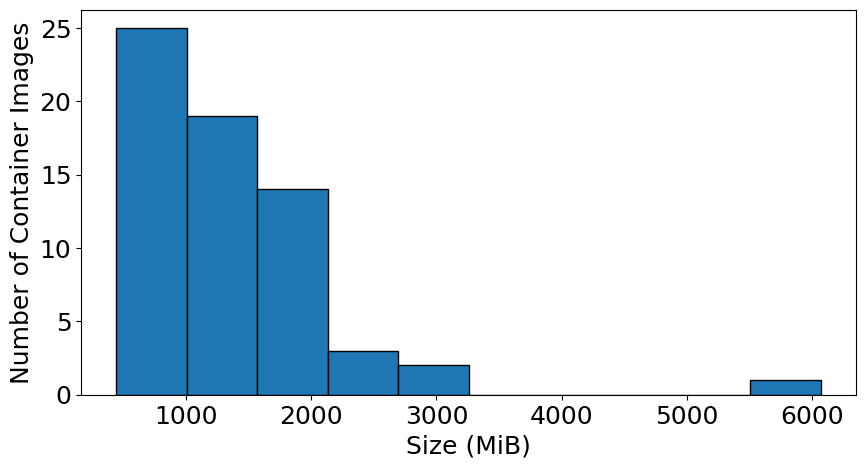

In [24]:
# Loading container images metadata
container_images = json.load(open("datasets/inputs/templates/container_images.json", "r"))

# Ignoring registry image
container_images = container_images[1:]

# Collecting size of images
image_sizes = [sum([layer["size"] for layer in image["layers"]])/1000000 for image in container_images]

# Plot size distribution
plt.rcParams.update({'font.size': 18})
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(image_sizes, bins=10, edgecolor="black")

# Customizing chart
customize_chart(
    ax,
    xlabel="Size (MiB)",
    ylabel="Number of Container Images",
)

# Saving figure
plt.savefig(f"{base_dir}/image_size_distribution.pdf", bbox_inches='tight')

### Container layers sharing information

In [20]:
container_layers = [layer for image in container_images for layer in image["layers"]]

layers_metadata = {}
for layer in container_layers:
    if layer["digest"] not in layers_metadata:
        layers_metadata[layer["digest"]] = {"size": layer["size"], "images_sharing": 1}
    else:
        layers_metadata[layer["digest"]]["images_sharing"] += 1

sharing_info = {}
for layer_metadata in layers_metadata.values():
    if layer_metadata["images_sharing"] not in sharing_info:
        sharing_info[layer_metadata["images_sharing"]] = { "total_size": layer_metadata["size"] }
    else:
        sharing_info[layer_metadata["images_sharing"]]["total_size"] += layer_metadata["size"]

total_size = sum([layer_metadata["size"] for layer_metadata in layers_metadata.values()])
for key in sharing_info:
    sharing_info[key]["percentage"] = round(sharing_info[key]["total_size"] / total_size * 100, 3)
    sharing_info[key]["total_size"] = round(sharing_info[key]["total_size"] / 1000000, 3)

layer_sharing_df = pd.DataFrame(sharing_info).T.sort_index()
layer_sharing_df.reset_index(inplace=True)
layer_sharing_df.columns = ["Number of Images Sharing", "Total Size (MiB)", "Percentage of Total Size (%)"]
layer_sharing_df["Number of Images Sharing"] = layer_sharing_df["Number of Images Sharing"].astype(str)
layer_sharing_df = pd.concat([layer_sharing_df, pd.DataFrame({"Number of Images Sharing": "Total", "Total Size (MiB)": layer_sharing_df["Total Size (MiB)"].sum(), "Percentage of Total Size (%)": 100}, index=[0])])

layer_sharing_latex_string = layer_sharing_df.to_latex(
    float_format="%.3f",
    column_format="lcc",
    escape=True,
    caption="AWS Deep Learning Container Layers Sharing Information.",
    label="tab:layer-sharing",
    index=False
).replace(
    "\\begin{table}", "\\begin{table}\n\\centering"
).replace(
    "Total &", "\midrule\nTotal &"
)

with open("logs/layer_sharing.tex", "w") as file:
    file.write(layer_sharing_latex_string)

### Datasets

## Results

### Latency: comparative table

In [37]:
latency_table = pd.DataFrame(
    {
        variation: user_data_dfs[variation]["Mean Latency"]
        for variation in variations
    }
)

latency_table.index = algorithm_labels

latency_table_latex_string = latency_table.to_latex(
    index=True,
    escape=True,
    header=False,
    label="tab:latency",
    column_format="lcccc",
    caption="Overall mean latency in time units (Equation~\\ref{eq:minimize-latency}).",
    float_format="{:0.2f}".format
).replace(
    "\\begin{table}",
    "\\begin{table}\n\centering"
).replace(
    "\\toprule",
    "\\toprule\nNodes & \multicolumn{2}{c}{100} & \multicolumn{2}{c}{196} \\\\\n\midrule\nUnique Images & 08 & 32 & 16 & 64 \\\\"
)

with open(f"{base_dir}/table_latency.tex", "w") as f:
    f.write(latency_table_latex_string)

### Resource usage (provisioned registries): comparative table

In [38]:
provisioned_registries_table = pd.DataFrame(
    {
        variation: registry_data_dfs[variation][0]["Mean Provisioned"]
        for variation in variations
    }
)

provisioned_registries_table.index = algorithm_labels

provisioned_registries_table_latex_string = provisioned_registries_table.to_latex(
    index=True,
    escape=True,
    header=False,
    label="tab:provisioned-registries",
    column_format="lcccc",
    caption="Mean number of provisioned registries per time step (Equation~\\ref{eq:minimize-computing}).",
    float_format="{:0.2f}".format
).replace(
    "\\begin{table}",
    "\\begin{table}\n\centering"
).replace(
    "\\toprule",
    "\\toprule\nNodes & \multicolumn{2}{c}{100} & \multicolumn{2}{c}{196} \\\\\n\midrule\nUnique Images & 08 & 32 & 16 & 64 \\\\"
)

with open(f"{base_dir}/table_provisioned_registries.tex", "w") as f:
    f.write(provisioned_registries_table_latex_string)

### Resource usage (provisioned registries along the time): line chart

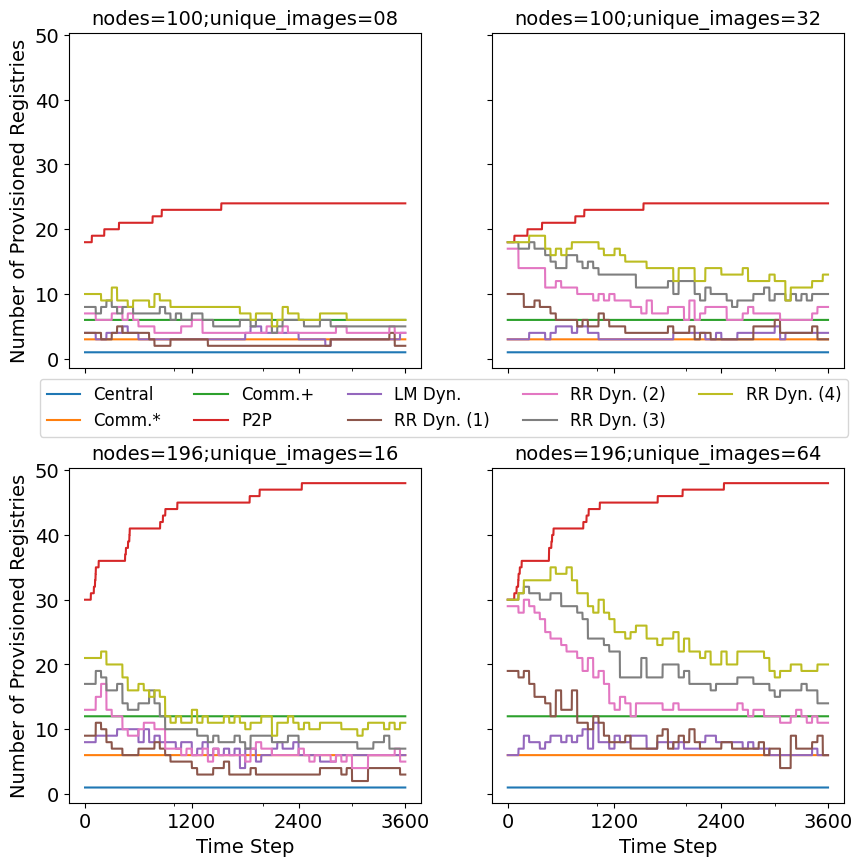

In [59]:
# TODO: check how to share labels
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 14, 'legend.fontsize': 12})
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, registry_data) in enumerate(registry_data_dfs.items()):
    registry_data[1].plot(ax=ax[counter // 2][counter % 2], legend=False, xticks=range(0, last_step + 1, 1200), yticks=range(0, 51, 10))
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel="Time Step",
        ylabel="Number of Provisioned Registries",
        title=key,
    )

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=5, bbox_to_anchor=(0.5, 0.505))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/provisioned_registries.pdf", bbox_inches='tight')

### Resource usage (server computing utilization along the time): line chart

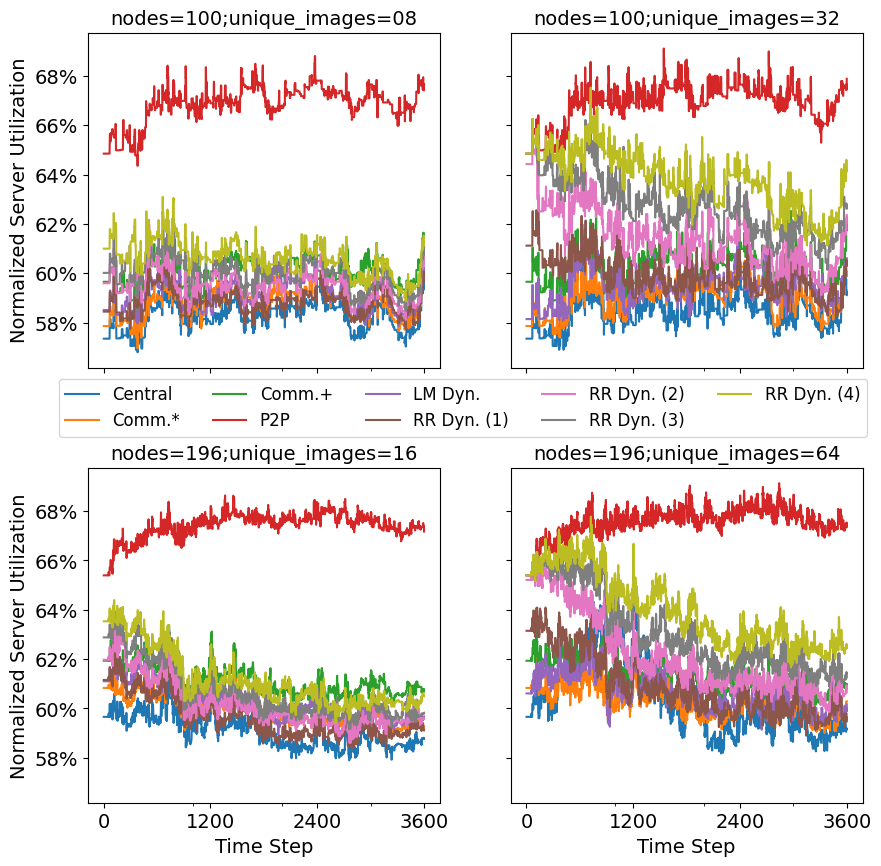

In [58]:
# TODO: check how to share labels
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 14, 'legend.fontsize': 12})
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, server_data) in enumerate(server_data_dfs.items()):
    server_data[0].plot(ax=ax[counter // 2][counter % 2], legend=False, xticks=range(0, last_step + 1, 1200), yticks=[0.58, 0.6, 0.62, 0.64, 0.66, 0.68])
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel="Time Step",
        ylabel="Normalized Server Utilization",
        title=key,
    )
    ax[counter // 2][counter % 2].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=5, bbox_to_anchor=(0.5, 0.505))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/server_utilization.pdf", bbox_inches='tight')

### Provisioning time: comparative table

In [56]:
provisioning_time_table = pd.DataFrame(
    {
        variation: application_data_dfs[variation]["Mean Prov. Time"]
        for variation in variations
    }
)

provisioning_time_table.index = algorithm_labels

provisioning_time_table_latex_string = provisioning_time_table.to_latex(
    index=True,
    escape=True,
    header=False,
    label="tab:provisioning-time",
    column_format="lcccc",
    caption="Overall provisioning time in seconds (Equation~\\ref{eq:minimize-provisioning-time}).",
    float_format="{:0.2f}".format
).replace(
    "\\begin{table}",
    "\\begin{table}\n\centering"
).replace(
    "\\toprule",
    "\\toprule\nNodes & \multicolumn{2}{c}{100} & \multicolumn{2}{c}{196} \\\\\n\midrule\nUnique Images & 08 & 32 & 16 & 64 \\\\"
)

with open(f"{base_dir}/table_provisioning_time.tex", "w") as f:
    f.write(provisioning_time_table_latex_string)

### Reallocations per type: stacker bar chart

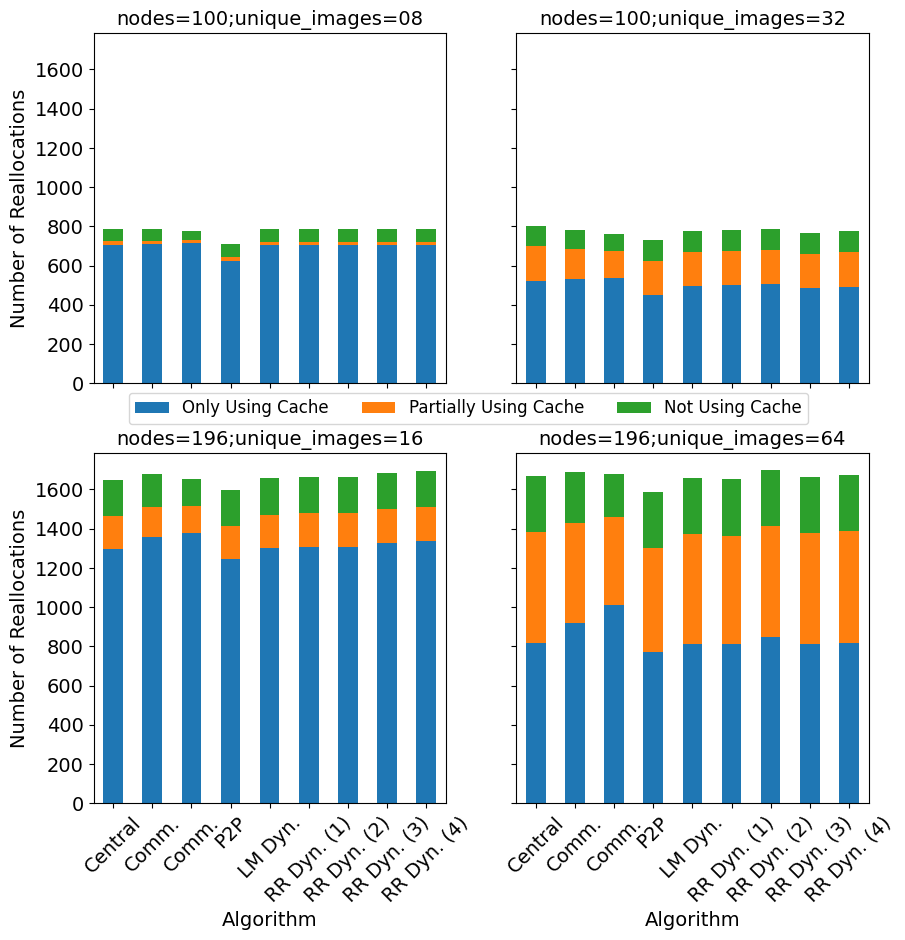

In [42]:
# TODO: check how to share labels
plt.rcParams.update({'font.size': 14, 'axes.titlesize': 14, 'legend.fontsize': 12})
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, application_data) in enumerate(application_data_dfs.items()):
    reallocations_df = application_data[["Algorithm", "Only Using Cache", "Partially Using Cache", "Not Using Cache"]]
    reallocations_df.plot.bar(x="Algorithm", stacked=True, ax=ax[counter // 2][counter % 2], rot=45, legend=False)
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel="Algorithm",
        ylabel="Number of Reallocations",
        title=key,
    )

handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center', ncols=3, bbox_to_anchor=(0.5, 0.505))
plt.subplots_adjust(hspace=0.2)

plt.savefig(f"{base_dir}/reallocations.pdf", bbox_inches='tight')

# TODO: add labels to the bars (%)

### Disk utilization: comparative table

In [55]:
disk_utilization_table = pd.DataFrame(
    {
        variation: server_data_dfs[variation][2]["Mean Disk Occupation per Server"]
        for variation in variations
    }
)

disk_utilization_table.index = algorithm_labels

disk_utilization_table_latex_string = disk_utilization_table.to_latex(
    index=True,
    escape=True,
    header=False,
    label="tab:disk-utilization",
    column_format="lcccc",
    caption="Mean disk utilization per edge server and time step in MiB (Equation~\\ref{eq:minimize-storage}).",
    float_format="{:0.2f}".format
).replace(
    "\\begin{table}",
    "\\begin{table}\n\centering"
).replace(
    "\\toprule",
    "\\toprule\nNodes & \multicolumn{2}{c}{100} & \multicolumn{2}{c}{196} \\\\\n\midrule\nUnique Images & 08 & 32 & 16 & 64 \\\\"
)

with open(f"{base_dir}/table_disk_utilization.tex", "w") as f:
    f.write(disk_utilization_table_latex_string)

### Disk utilization along the time: line chart

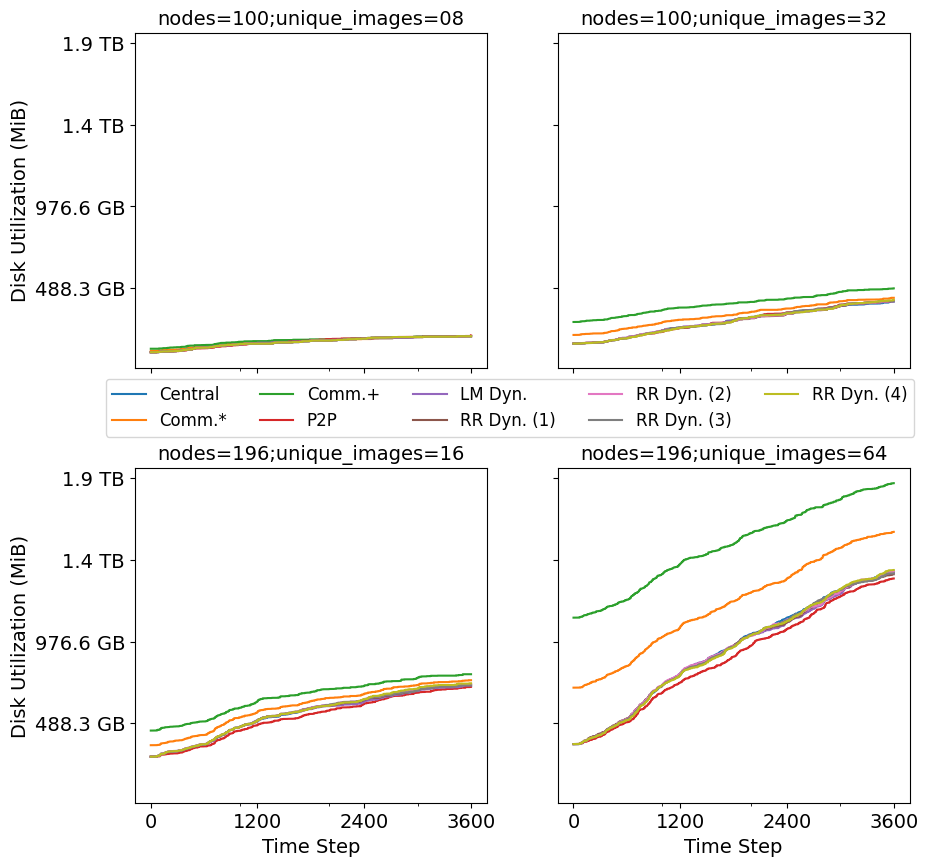

In [57]:
def sizeof_fmt(x, pos):
    if x < 0:
        return ""
    for x_unit in ['MB', 'GB', 'TB']:
        if x < 1024.0:
            return "%3.1f %s" % (x, x_unit)
        x /= 1024.0

# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, server_data) in enumerate(server_data_dfs.items()):
    server_data[1].plot(ax=ax[counter // 2][counter % 2], legend=False, xticks=range(0, last_step + 1, 1200))
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel="Time Step",
        ylabel="Disk Utilization (MiB)",
        title=key,
    )
    ax[counter // 2][counter % 2].yaxis.set_major_formatter(mticker.FuncFormatter(sizeof_fmt))

handles, _ = plt.gca().get_legend_handles_labels()
fig.legend(handles, algorithm_labels, loc='center', ncols=5, bbox_to_anchor=(0.5, 0.505))
plt.subplots_adjust(hspace=0.3)

plt.savefig(f"{base_dir}/disk_utilization.pdf", bbox_inches='tight')

### Registry usage (percentage of active steps): boxplot chart

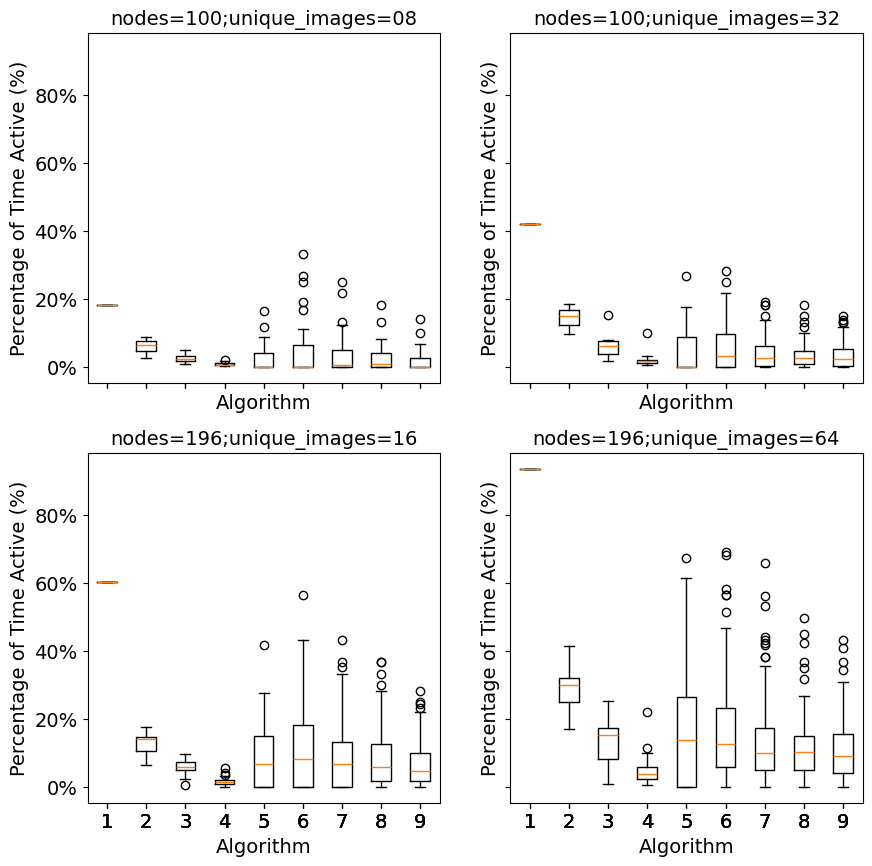

In [61]:
# TODO: check how to share labels
fig, ax = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

for counter, (key, registry_data) in enumerate(registry_data_dfs.items()):
    registry_usage_df = registry_data[0][["Algorithm", "Values"]]
    ax[counter // 2][counter % 2].boxplot(registry_usage_df["Values"])
    customize_chart(
        ax[counter // 2][counter % 2],
        xlabel="Algorithm",
        ylabel="Percentage of Time Active (%)",
        title=key,
    )
    ax[counter // 2][counter % 2].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))

plt.savefig(f"{base_dir}/active_registries.pdf", bbox_inches='tight')

# TODO: customize outliers

### Image replication

In [65]:
target_variation = "nodes=100;unique_images=32"

image_replication_data = [
    get_image_replication_data(log, target_variation) for log in logs[3:]
]

headers = [
    image_replication_data[index].columns.values.tolist() for index in range(len(image_replication_data))
]

max_length = max([len(header) for header in headers])
header_with_max_length = headers[[len(header) for header in headers].index(max_length)]

global_colormap = mpl.colormaps["tab20c"].resampled(max_length)

In [66]:
# TODO: fix when it does not start with zero
headers

[[0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23],
 [0, 1, 2, 3, 4],
 [0, 1, 2, 3, 4, 5],
 [0, 1, 2, 3, 4, 5, 6, 7],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]]

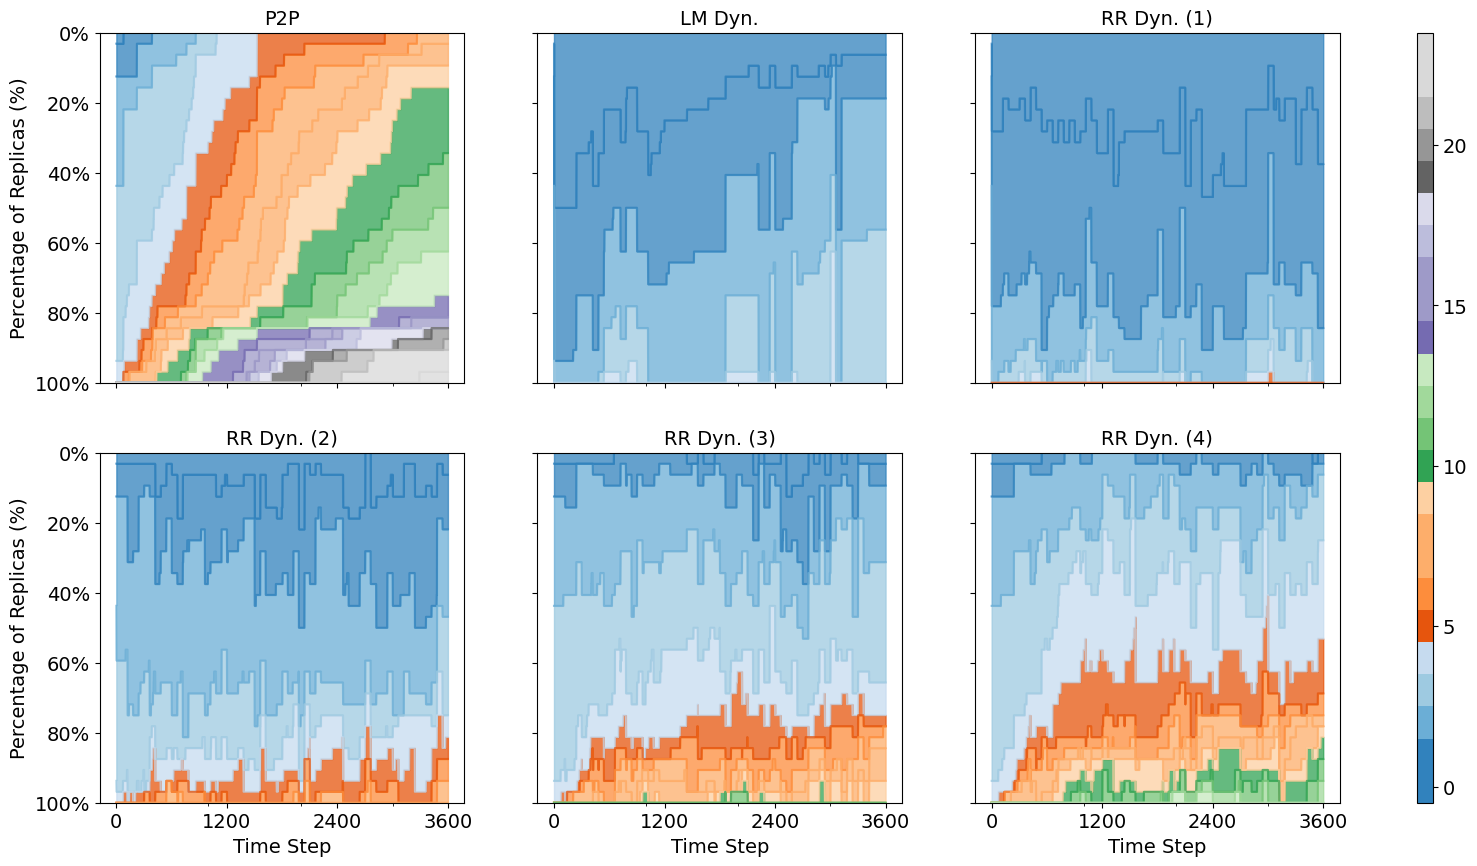

In [67]:
# plot stacked area chart for each algorithm in multiple figures using a single legend
fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharex=True, sharey=True)

for counter, image_replication_df in enumerate(image_replication_data):
    local_color_map = mpl.colors.ListedColormap(global_colormap.colors[:len(image_replication_df.columns)])
    image_replication_df.plot.area(ax=ax[counter // 3][counter % 3], legend=False, alpha=0.75, cmap=local_color_map, xticks=range(0, last_step + 1, 1200))
    ax[counter // 3][counter % 3].set_ylim([0, 1])
    ax[counter // 3][counter % 3].invert_yaxis()
    customize_chart(
        ax[counter // 3][counter % 3],
        xlabel="Time Step",
        ylabel="Percentage of Replicas (%)",
        title=algorithm_labels[counter+3],
    )

# percentage formatter
ax[0][0].yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1, decimals=0))

# create a single colorbar for all figures
fig.colorbar(mpl.cm.ScalarMappable(cmap=global_colormap), ax=ax, orientation="vertical", aspect=50, values=header_with_max_length)

plt.savefig(f"{base_dir}/image_replication.pdf", bbox_inches='tight')